
Source: https://www.kaggle.com/c/facial-keypoints-detection/overview

Source: https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data


#  IMPORT LIBRARIES AND DATASETS

In [45]:
# Mount the drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [46]:
%cd /content/drive/My Drive/Colab Notebooks/Emotion AI/


/content/drive/My Drive/Colab Notebooks/Emotion AI


In [47]:
# Import the necessary packages

import pandas as pd
import numpy as np
import os
import PIL
import seaborn as sns
import pickle
from PIL import *
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.python.keras import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from keras import optimizers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow

In [48]:
# load facial key points data
keyfacial_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Emotion AI/Dataset/data.csv')

In [49]:
# Show only first 2 rows
keyfacial_df.head(2)

left_eye_center_x  ...                                              Image
0          66.033564  ...  238 236 237 238 240 240 239 241 241 243 240 23...
1          64.332936  ...  219 215 204 196 204 211 212 200 180 168 178 19...

[2 rows x 31 columns]

In [50]:
# Obtain relavant information about the dataframe
keyfacial_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2140 entries, 0 to 2139
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          2140 non-null   float64
 1   left_eye_center_y          2140 non-null   float64
 2   right_eye_center_x         2140 non-null   float64
 3   right_eye_center_y         2140 non-null   float64
 4   left_eye_inner_corner_x    2140 non-null   float64
 5   left_eye_inner_corner_y    2140 non-null   float64
 6   left_eye_outer_corner_x    2140 non-null   float64
 7   left_eye_outer_corner_y    2140 non-null   float64
 8   right_eye_inner_corner_x   2140 non-null   float64
 9   right_eye_inner_corner_y   2140 non-null   float64
 10  right_eye_outer_corner_x   2140 non-null   float64
 11  right_eye_outer_corner_y   2140 non-null   float64
 12  left_eyebrow_inner_end_x   2140 non-null   float64
 13  left_eyebrow_inner_end_y   2140 non-null   float

In [51]:
# Check if null values exist in the dataframe
keyfacial_df.isnull().sum()

left_eye_center_x            0
left_eye_center_y            0
right_eye_center_x           0
right_eye_center_y           0
left_eye_inner_corner_x      0
left_eye_inner_corner_y      0
left_eye_outer_corner_x      0
left_eye_outer_corner_y      0
right_eye_inner_corner_x     0
right_eye_inner_corner_y     0
right_eye_outer_corner_x     0
right_eye_outer_corner_y     0
left_eyebrow_inner_end_x     0
left_eyebrow_inner_end_y     0
left_eyebrow_outer_end_x     0
left_eyebrow_outer_end_y     0
right_eyebrow_inner_end_x    0
right_eyebrow_inner_end_y    0
right_eyebrow_outer_end_x    0
right_eyebrow_outer_end_y    0
nose_tip_x                   0
nose_tip_y                   0
mouth_left_corner_x          0
mouth_left_corner_y          0
mouth_right_corner_x         0
mouth_right_corner_y         0
mouth_center_top_lip_x       0
mouth_center_top_lip_y       0
mouth_center_bottom_lip_x    0
mouth_center_bottom_lip_y    0
Image                        0
dtype: int64

In [52]:
keyfacial_df['Image'].shape

(2140,)

In [53]:
# Since values for the image are given as space separated string, separate the values using ' ' as separator.
# Then convert this into numpy array using np.fromstring and convert the obtained 1D array into 2D array of shape (96, 96)
keyfacial_df['Image'] = keyfacial_df['Image'].apply(lambda x: np.fromstring(x, dtype = int, sep = ' ').reshape(96, 96))

In [54]:
# Obtain the Shape of the image
keyfacial_df['Image'][0].shape

(96, 96)

In [55]:
keyfacial_df.describe()

left_eye_center_x  ...  mouth_center_bottom_lip_y
count        2140.000000  ...                2140.000000
mean           66.221549  ...                  82.630412
std             2.087683  ...                   4.813557
min            47.835757  ...                  57.232296
25%            65.046300  ...                  79.417480
50%            66.129065  ...                  82.388899
75%            67.332093  ...                  85.697976
max            78.013082  ...                  95.808983

[8 rows x 30 columns]

#  PERFORM IMAGE VISUALIZATION

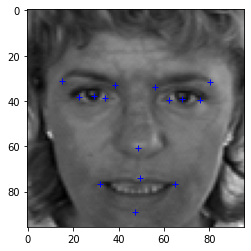

In [56]:
# Plot a random image from the dataset along with facial keypoints. 
# Image data is obtained from df['Image'] and plotted using plt.imshow
# 15 x and y coordinates for the corresponding image 
# since x-coordinates are in even columns like 0,2,4,.. and y-coordinates are in odd columns like 1,3,5,..
# we access their value using .loc command, which get the values for coordinates of the image based on the column it is refering to.

i = np.random.randint(1, len(keyfacial_df))
plt.imshow(keyfacial_df['Image'][i], cmap = 'gray')
for j in range(1, 31, 2):
        plt.plot(keyfacial_df.loc[i][j-1], keyfacial_df.loc[i][j], 'b+')


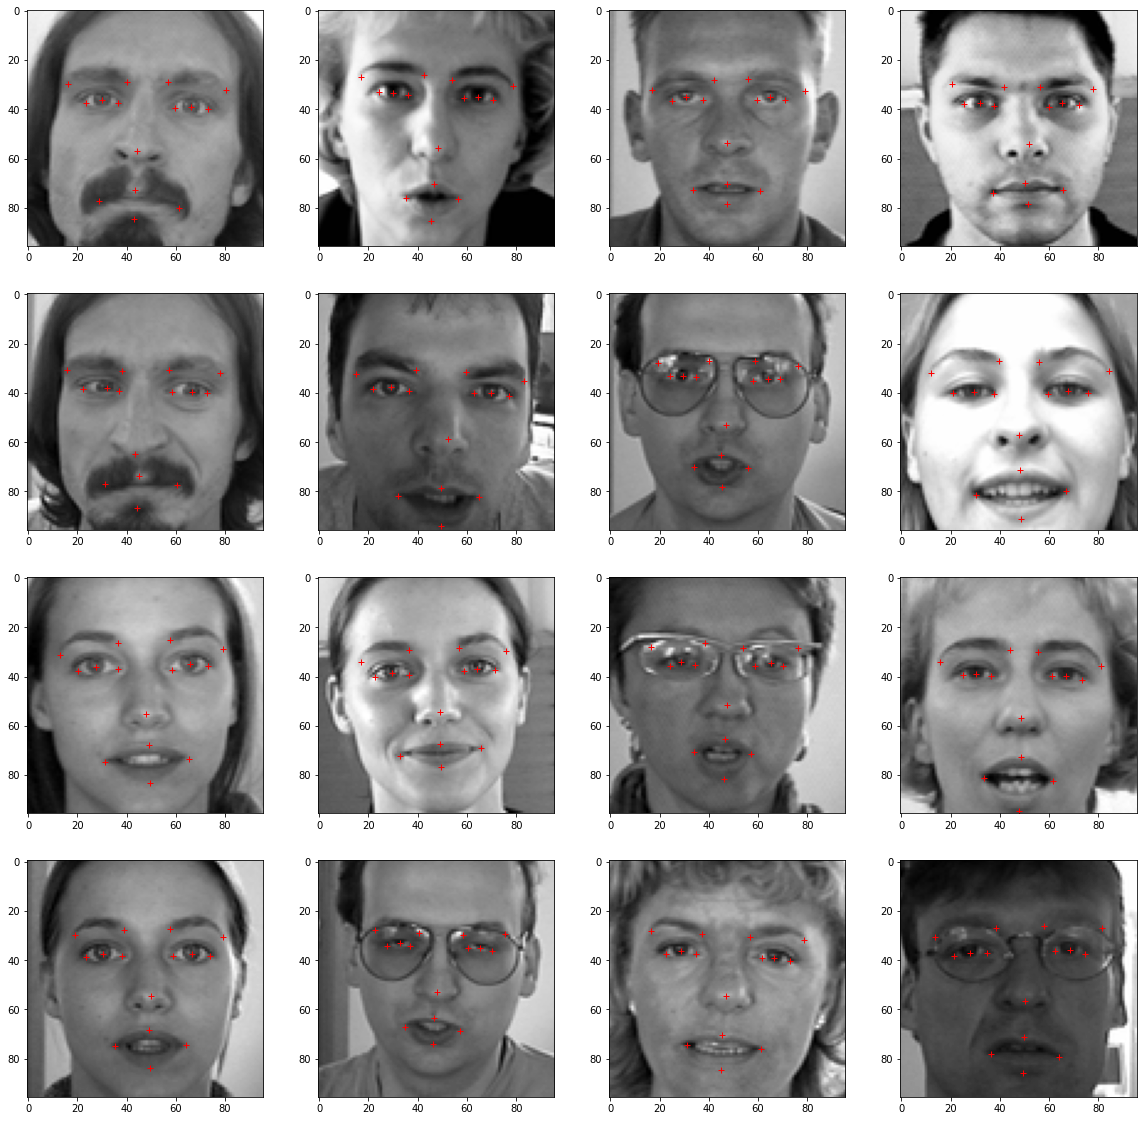

In [57]:
# Let's view more images in a grid format
fig = plt.figure(figsize=(20, 20))

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1)    
    image = plt.imshow(keyfacial_df['Image'][i],cmap = 'gray')
    for j in range(1,31,2):
        plt.plot(keyfacial_df.loc[i][j-1], keyfacial_df.loc[i][j], 'r+')
    

#### Visualizing 64 new images along with their cooresponding key points

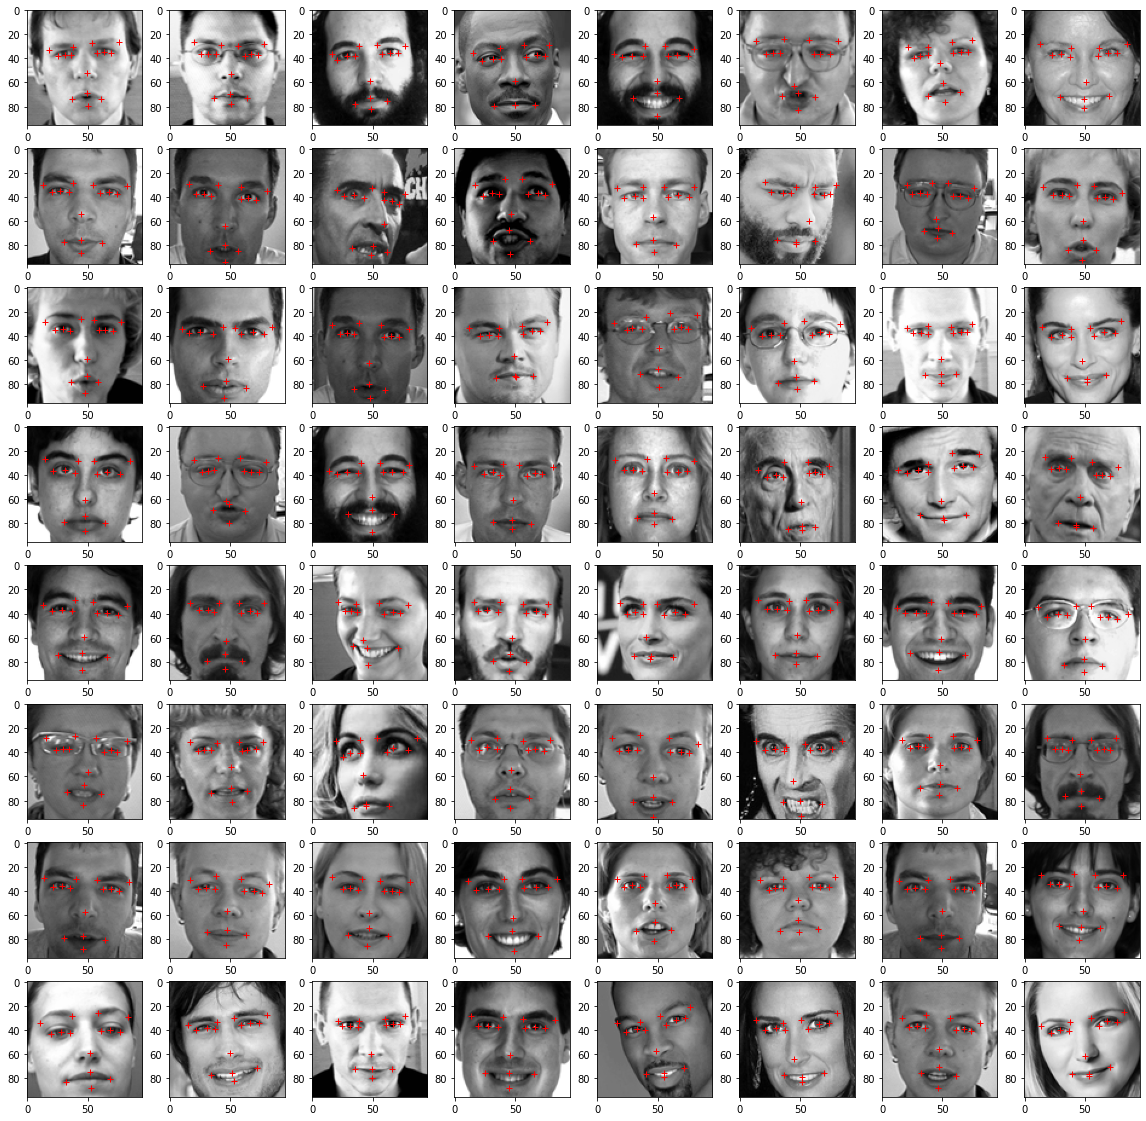

In [58]:
import random
# Let's view more images in a grid format
fig = plt.figure(figsize=(20, 20))

for i in range(64):
    k = random.randint(1, len(keyfacial_df))
    ax = fig.add_subplot(8, 8, i + 1)    
    image = plt.imshow(keyfacial_df['Image'][k],cmap = 'gray')
    for j in range(1,31,2):
        plt.plot(keyfacial_df.loc[k][j-1], keyfacial_df.loc[k][j], 'r+')
    

# TASK #4: PERFORM IMAGE AUGMENTATION

In [59]:
# Create a new copy of the dataframe
import copy
keyfacial_df_copy = copy.copy(keyfacial_df)

In [60]:
# Obtain the columns in the dataframe

columns = keyfacial_df_copy.columns[:-1]
columns

Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y'],
      dtype='object')

In [61]:
# Horizontal Flip - flip the images along y axis
keyfacial_df_copy['Image'] = keyfacial_df_copy['Image'].apply(lambda x: np.flip(x, axis = 1))

# since we are flipping horizontally, y coordinate values would be the same
# Only x coordiante values would change, all we have to do is to subtract our initial x-coordinate values from width of the image(96)
for i in range(len(columns)):
  if i%2 == 0:
    keyfacial_df_copy[columns[i]] = keyfacial_df_copy[columns[i]].apply(lambda x: 96. - float(x) )

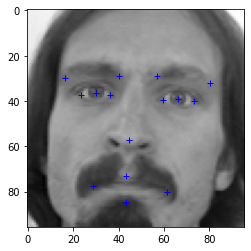

In [62]:
# Show the Original image
plt.imshow(keyfacial_df['Image'][0], cmap = 'gray')
for j in range(1, 31, 2):
        plt.plot(keyfacial_df.loc[0][j-1], keyfacial_df.loc[0][j], 'b+')

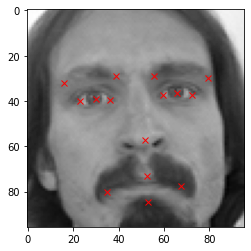

In [63]:
# Show the Horizontally flipped image
plt.imshow(keyfacial_df_copy['Image'][0],cmap='gray')
for j in range(1, 31, 2):
        plt.plot(keyfacial_df_copy.loc[0][j-1], keyfacial_df_copy.loc[0][j], 'rx')

In [64]:
# Concatenate the original dataframe with the augmented dataframe
augmented_df = np.concatenate((keyfacial_df, keyfacial_df_copy))

In [65]:
augmented_df.shape

(4280, 31)

In [66]:
# Randomingly increasing the brightness of the images
# We multiply pixel values by random values between 1.5 and 2 to increase the brightness of the image
# we clip the value between 0 and 255
# The concatenate the augmented_df after flipping with the new one after increase the brightness
import random

keyfacial_df_copy = copy.copy(keyfacial_df)
keyfacial_df_copy['Image'] = keyfacial_df_copy['Image'].apply(lambda x:np.clip(random.uniform(1.5, 2)* x, 0.0, 255.0))
augmented_df = np.concatenate((augmented_df, keyfacial_df_copy))
augmented_df.shape

(6420, 31)

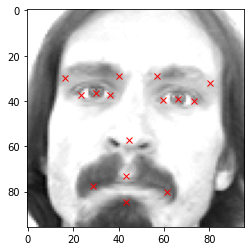

In [67]:
# Show Image with increased brightness

plt.imshow(keyfacial_df_copy['Image'][0], cmap='gray')
for j in range(1, 31, 2):
        plt.plot(keyfacial_df_copy.loc[0][j-1], keyfacial_df_copy.loc[0][j], 'rx')

#### Augment images by flipping them vertically 


In [68]:
keyfacial_df_copy = copy.copy(keyfacial_df)

In [69]:
keyfacial_df_copy['Image'] = keyfacial_df_copy['Image'].apply(lambda x: np.flip(x, axis = 0))
# Note flipping vertically make changes only in y axis only
for i in range(len(columns)):
  if i%2 == 1:
    keyfacial_df_copy[columns[i]] = keyfacial_df_copy[columns[i]].apply(lambda x: 96. - float(x) )

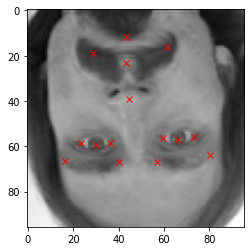

In [70]:
plt.imshow(keyfacial_df_copy['Image'][0], cmap='gray')
for j in range(1, 31, 2):
        plt.plot(keyfacial_df_copy.loc[0][j-1], keyfacial_df_copy.loc[0][j], 'rx')



#### PERFORM DATA NORMALIZATION AND TRAINING DATA PREPARATION

In [71]:
# Obtain the value of images which is present in the 31st column (since index start from 0, we refer to 31st column by 30)
img = augmented_df[:,30]

# Normalize the images
img = img/255.

# Create an empty array of shape (x, 96, 96, 1) to feed the model
X = np.empty((len(img), 96, 96, 1))

# Iterate through the img list and add image values to the empty array after expanding it's dimension from (96, 96) to (96, 96, 1)
for i in range(len(img)):
  X[i,] = np.expand_dims(img[i], axis = 2)

# Convert the array type to float32
X = np.asarray(X).astype(np.float32)
X.shape

(6420, 96, 96, 1)

In [72]:
# Obtain the value of x & y coordinates which are to used as target.
y = augmented_df[:,:30]
y = np.asarray(y).astype(np.float32)
y.shape

(6420, 30)

In [73]:
# Split the data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [74]:
X_train.shape

(5136, 96, 96, 1)

In [75]:
X_test.shape

(1284, 96, 96, 1)

#### BUILD DEEP RESIDUAL NEURAL NETWORK KEY FACIAL POINTS DETECTION MODEL 

In [96]:
def res_block(X, filter, stage):

  # Convolutional_block
  X_copy = X

  f1 , f2, f3 = filter

  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_conv_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = MaxPool2D((2,2))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_conv_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_c')(X)


  # Short path
  X_copy = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_copy', kernel_initializer= glorot_uniform(seed = 0))(X_copy)
  X_copy = MaxPool2D((2,2))(X_copy)
  X_copy = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_copy')(X_copy)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  
  # Identity Block 1
  X_copy = X


  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_1_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_1_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_1_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_c')(X)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  # Identity Block 2
  X_copy = X


  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_2_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_2_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_2_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_c')(X)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [97]:
input_shape = (96, 96, 1)

# Input tensor shape
X_input = Input(input_shape)

# Zero-padding
X = ZeroPadding2D((3,3))(X_input)

# 1 - stage
X = Conv2D(64, (7,7), strides= (2,2), name = 'conv1', kernel_initializer= glorot_uniform(seed = 0))(X)
X = BatchNormalization(axis =3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3,3), strides= (2,2))(X)

# 2 - stage
X = res_block(X, filter= [64,64,256], stage= 2)

# 3 - stage
X = res_block(X, filter= [128,128,512], stage= 3)


# Average Pooling
X = AveragePooling2D((2,2), name = 'Averagea_Pooling')(X)

# Final layer
X = Flatten()(X)
X = Dense(4096, activation = 'relu')(X)
X = Dropout(0.2)(X)
X = Dense(2048, activation = 'relu')(X)
X = Dropout(0.1)(X)
X = Dense(30, activation = 'relu')(X)


model_1_facialKeyPoints = Model( inputs= X_input, outputs = X)
model_1_facialKeyPoints.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 96, 96, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 102, 102, 1)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 48, 48, 64)   3200        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 48, 48, 64)   256         conv1[0][0]                      
____________________________________________________________________________________________

#### COMPILE AND TRAIN KEY FACIAL POINTS DETECTION DEEP LEARNING MODEL

In [98]:
adam = tf.keras.optimizers.Adam(learning_rate = 0.0001, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False)
model_1_facialKeyPoints.compile(loss = "mean_squared_error", optimizer = adam , metrics = ['accuracy'])


In [99]:
# save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath = "FacialKeyPoints_weights.hdf5", verbose = 1, save_best_only = True)

In [100]:
history = model_1_facialKeyPoints.fit(X_train, y_train, batch_size = 43, epochs = 20, validation_split = 0.05, callbacks=[checkpointer])

Epoch 1/20
114/114 [==============================] - 5s 29ms/step - loss: 698.1487 - accuracy: 0.3656 - val_loss: 1274.5621 - val_accuracy: 0.7237

Epoch 00001: val_loss improved from inf to 1274.56213, saving model to FacialKeyPoints_weights.hdf5
Epoch 2/20
114/114 [==============================] - 3s 24ms/step - loss: 124.6594 - accuracy: 0.5975 - val_loss: 520.9919 - val_accuracy: 0.7237

Epoch 00002: val_loss improved from 1274.56213 to 520.99188, saving model to FacialKeyPoints_weights.hdf5
Epoch 3/20
114/114 [==============================] - 3s 24ms/step - loss: 77.3396 - accuracy: 0.5811 - val_loss: 345.2289 - val_accuracy: 0.7237

Epoch 00003: val_loss improved from 520.99188 to 345.22888, saving model to FacialKeyPoints_weights.hdf5
Epoch 4/20
114/114 [==============================] - 3s 24ms/step - loss: 53.2341 - accuracy: 0.5594 - val_loss: 161.4788 - val_accuracy: 0.7237

Epoch 00004: val_loss improved from 345.22888 to 161.47876, saving model to FacialKeyPoints_weight

In [101]:
# save the model architecture to json file for future use

model_json = model_1_facialKeyPoints.to_json()
with open("FacialKeyPoints-model.json","w") as json_file:
  json_file.write(model_json)


#### ASSESS TRAINED KEY FACIAL POINTS DETECTION MODEL PERFORMANCE

In [107]:
with open('/content/drive/My Drive/Colab Notebooks/Emotion AI/Dataset/detection.json', 'r') as json_file:
    json_savedModel= json_file.read()
    
# load the model architecture 
model_1_facialKeyPoints = tf.keras.models.model_from_json(json_savedModel)
model_1_facialKeyPoints.load_weights('FacialKeyPoints_weights.hdf5')
adam = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model_1_facialKeyPoints.compile(loss="mean_squared_error", optimizer= adam , metrics = ['accuracy'])

In [108]:
# Evaluate the model

result = model_1_facialKeyPoints.evaluate(X_test, y_test)
print("Accuracy : {}".format(result[1]))

41/41 [==============================] - 1s 8ms/step - loss: 74.9000 - accuracy: 0.6964
Accuracy : 0.6931464076042175


In [109]:
# Get the model keys 
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

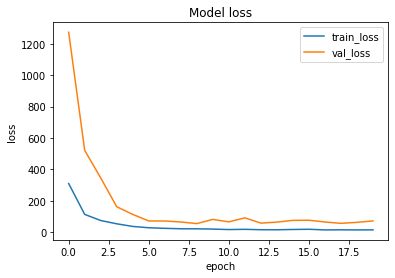

In [110]:
# Plot the training artifacts

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'], loc = 'upper right')
plt.show()

### FACIAL EXPRESSION DETECTION

###### IMPORT & EXPLORE DATASET FOR FACIAL EXPRESSION DETECTION

In [112]:
# read the csv files for the facial expression data
facialexpression_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Emotion AI/Dataset/icml_face_data.csv')

In [113]:
facialexpression_df

emotion                                             pixels
0            0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1            0  151 150 147 155 148 133 111 140 170 174 182 15...
2            2  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
3            2  20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...
4            3  77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...
...        ...                                                ...
24563        3  0 39 81 80 104 97 51 64 68 46 41 67 53 68 70 5...
24564        0  181 177 176 156 178 144 136 132 122 107 131 16...
24565        3  178 174 172 173 181 188 191 194 196 199 200 20...
24566        0  17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...
24567        3  30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...

[24568 rows x 2 columns]

In [114]:
facialexpression_df[' pixels'][0] # String format

'70 80 82 72 58 58 60 63 54 58 60 48 89 115 121 119 115 110 98 91 84 84 90 99 110 126 143 153 158 171 169 172 169 165 129 110 113 107 95 79 66 62 56 57 61 52 43 41 65 61 58 57 56 69 75 70 65 56 54 105 146 154 151 151 155 155 150 147 147 148 152 158 164 172 177 182 186 189 188 190 188 180 167 116 95 103 97 77 72 62 55 58 54 56 52 44 50 43 54 64 63 71 68 64 52 66 119 156 161 164 163 164 167 168 170 174 175 176 178 179 183 187 190 195 197 198 197 198 195 191 190 145 86 100 90 65 57 60 54 51 41 49 56 47 38 44 63 55 46 52 54 55 83 138 157 158 165 168 172 171 173 176 179 179 180 182 185 187 189 189 192 197 200 199 196 198 200 198 197 177 91 87 96 58 58 59 51 42 37 41 47 45 37 35 36 30 41 47 59 94 141 159 161 161 164 170 171 172 176 178 179 182 183 183 187 189 192 192 194 195 200 200 199 199 200 201 197 193 111 71 108 69 55 61 51 42 43 56 54 44 24 29 31 45 61 72 100 136 150 159 163 162 163 170 172 171 174 177 177 180 187 186 187 189 192 192 194 195 196 197 199 200 201 200 197 201 137 58 98 92

In [115]:
# function to convert pixel values in string format to array format

def string2array(x):
  return np.array(x.split(' ')).reshape(48, 48, 1).astype('float32')

In [116]:
# Resize images from (48, 48) to (96, 96)

def resize(x):
  
  img = x.reshape(48, 48)
  return cv2.resize(img, dsize=(96, 96), interpolation = cv2.INTER_CUBIC)

In [117]:
facialexpression_df[' pixels'] = facialexpression_df[' pixels'].apply(lambda x: string2array(x))

In [118]:
facialexpression_df[' pixels'] = facialexpression_df[' pixels'].apply(lambda x: resize(x))

In [119]:
facialexpression_df.head()

emotion                                             pixels
0        0  [[69.316925, 73.03865, 79.13719, 84.17186, 85....
1        0  [[151.09435, 150.91393, 150.65791, 148.96367, ...
2        2  [[23.061905, 25.50914, 29.47847, 33.99843, 36....
3        2  [[20.083221, 19.079437, 17.398712, 17.158691, ...
4        3  [[76.26172, 76.54747, 77.001785, 77.7672, 78.4...

In [120]:
# check the shape of data_frame
facialexpression_df.shape

(24568, 2)

In [121]:
# check for the presence of null values in the data frame
facialexpression_df.isnull().sum()

emotion    0
 pixels    0
dtype: int64

In [122]:
label_to_text = {0:'anger', 1:'disgust', 2:'sad', 3:'happiness', 4: 'surprise'}

###### Visualize the first image in the dataframe and make sure that the image is not distorted by resizing or reshaping operations

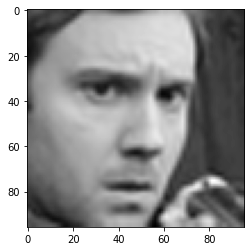

In [123]:
plt.imshow(facialexpression_df[' pixels'][0], cmap = 'gray')

##### VISUALIZE IMAGES AND PLOT LABELS

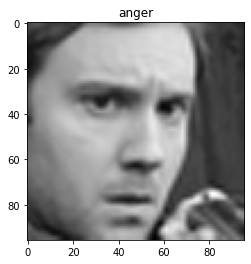

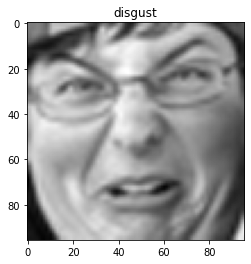

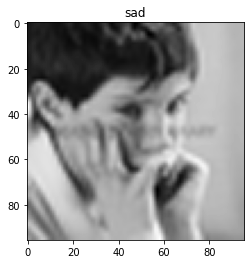

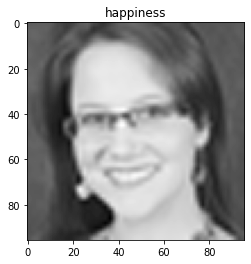

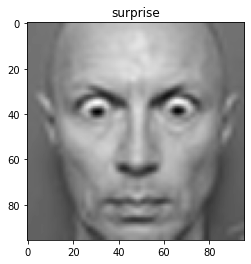

In [124]:
emotions = [0, 1, 2, 3, 4]

for i in emotions:
  data = facialexpression_df[facialexpression_df['emotion'] == i][:1]
  img = data[' pixels'].item()
  img = img.reshape(96, 96)
  plt.figure()
  plt.title(label_to_text[i])
  plt.imshow(img, cmap = 'gray')

MINI CHALLENGE #13: 
- Plot bar chart to outline how many samples (images) are present per emotion

In [125]:
facialexpression_df.emotion.value_counts().index

Int64Index([3, 2, 0, 4, 1], dtype='int64')

In [126]:
facialexpression_df.emotion.value_counts()

3    8989
2    6077
0    4953
4    4002
1     547
Name: emotion, dtype: int64

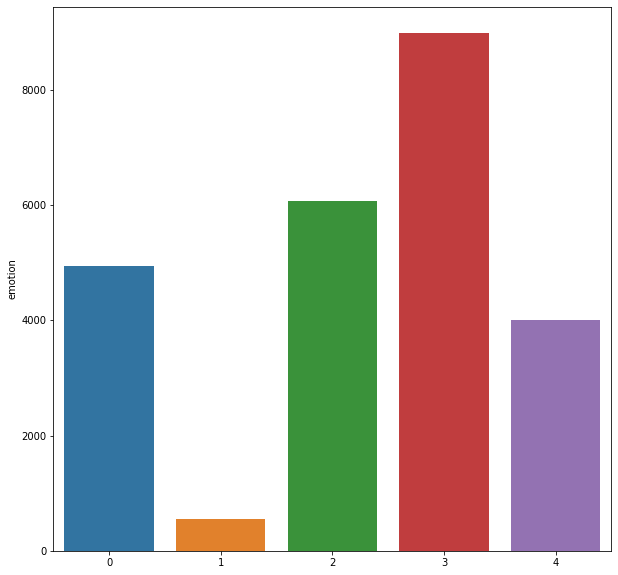

In [127]:
plt.figure(figsize = (10,10))
sns.barplot(x = facialexpression_df.emotion.value_counts().index, y = facialexpression_df.emotion.value_counts())

#### PERFORM DATA PREPARATION AND IMAGE AUGMENTATION

In [128]:
# split the dataframe in to features and labels
from keras.utils import to_categorical

X = facialexpression_df[' pixels']
y = to_categorical(facialexpression_df['emotion'])


In [129]:
X[0]

array([[ 69.316925,  73.03865 ,  79.13719 , ...,  40.73619 ,  40.6584  ,
         40.5394  ],
       [ 68.66325 ,  70.95224 ,  74.71768 , ...,  43.274765,  42.037186,
         41.223618],
       [ 67.768814,  67.71646 ,  67.67172 , ...,  47.39473 ,  44.26329 ,
         42.31465 ],
       ...,
       [ 74.89021 ,  76.79553 ,  79.90259 , ...,  71.463425,  59.32875 ,
         51.74736 ],
       [ 76.68126 ,  75.808105,  74.25452 , ...,  93.943375,  79.77934 ,
         71.13246 ],
       [ 77.63858 ,  75.15074 ,  70.8846  , ..., 107.66351 ,  92.23212 ,
         82.91585 ]], dtype=float32)

In [130]:
y

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]], dtype=float32)

In [131]:

X = np.stack(X, axis = 0)
X = X.reshape(24568, 96, 96, 1)

print(X.shape, y.shape)

(24568, 96, 96, 1) (24568, 5)


In [132]:
# split the dataframe in to train, test and validation data frames

from sklearn.model_selection import train_test_split

X_train, X_Test, y_train, y_Test = train_test_split(X, y, test_size = 0.1, shuffle = True)
X_val, X_Test, y_val, y_Test = train_test_split(X_Test, y_Test, test_size = 0.5, shuffle = True)


In [133]:
print(X_val.shape, y_val.shape)

(1228, 96, 96, 1) (1228, 5)


In [134]:
print(X_Test.shape, y_Test.shape)

(1229, 96, 96, 1) (1229, 5)


In [135]:
print(X_train.shape, y_train.shape)

(22111, 96, 96, 1) (22111, 5)


In [136]:
# image pre-processing

X_train = X_train/255
X_val   = X_val /255
X_Test  = X_Test/255

In [137]:
X_train

array([[[[0.3644898 ],
         [0.37453535],
         [0.3918673 ],
         ...,
         [0.84725565],
         [0.86680377],
         [0.87864584]],

        [[0.36981124],
         [0.37110716],
         [0.37382287],
         ...,
         [0.8458162 ],
         [0.8654559 ],
         [0.8773438 ]],

        [[0.37769493],
         [0.3645685 ],
         [0.34318227],
         ...,
         [0.8434454 ],
         [0.8632359 ],
         [0.87519914]],

        ...,

        [[0.04717617],
         [0.04854234],
         [0.05060508],
         ...,
         [0.52857053],
         [0.60443866],
         [0.6500147 ]],

        [[0.03576487],
         [0.03629509],
         [0.03684034],
         ...,
         [0.4974127 ],
         [0.5948308 ],
         [0.6531385 ]],

        [[0.02893455],
         [0.0289382 ],
         [0.02853441],
         ...,
         [0.4776807 ],
         [0.58910686],
         [0.6556932 ]]],


       [[[0.9291165 ],
         [0.90975213],
         [0.88

In [138]:
train_datagen = ImageDataGenerator(
rotation_range = 15,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip = True,
    fill_mode = "nearest")


#### BUILD AND TRAIN DEEP LEARNING MODEL FOR FACIAL EXPRESSION CLASSIFICATION

In [139]:
input_shape = (96, 96, 1)

# Input tensor shape
X_input = Input(input_shape)

# Zero-padding
X = ZeroPadding2D((3, 3))(X_input)

# 1 - stage
X = Conv2D(64, (7, 7), strides= (2, 2), name = 'conv1', kernel_initializer= glorot_uniform(seed = 0))(X)
X = BatchNormalization(axis =3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3, 3), strides= (2, 2))(X)

# 2 - stage
X = res_block(X, filter= [64, 64, 256], stage= 2)

# 3 - stage
X = res_block(X, filter= [128, 128, 512], stage= 3)

# 4 - stage
# X = res_block(X, filter= [256, 256, 1024], stage= 4)

# Average Pooling
X = AveragePooling2D((4, 4), name = 'Averagea_Pooling')(X)

# Final layer
X = Flatten()(X)
X = Dense(5, activation = 'softmax', name = 'Dense_final', kernel_initializer= glorot_uniform(seed=0))(X)

model_2_emotion = Model( inputs= X_input, outputs = X, name = 'Resnet18')

model_2_emotion.summary()

Model: "Resnet18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 96, 96, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 102, 102, 1)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 48, 48, 64)   3200        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 48, 48, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

In [162]:
# train the network
model_2_emotion.compile(optimizer = "Adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [163]:
# Recall that the first facial key points model was saved as follows: FacialKeyPoints_weights.hdf5 and FacialKeyPoints-model.json

# using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 20)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath = "FacialExpression_weights.hdf5", verbose = 1, save_best_only=True)

In [164]:
history = model_2_emotion.fit(train_datagen.flow(X_train, y_train, batch_size=54),
	validation_data=(X_val, y_val), steps_per_epoch=len(X_train) // 64,
	epochs= 6, callbacks=[checkpointer, earlystopping])

Epoch 1/6
345/345 [==============================] - 20s 51ms/step - loss: 0.6128 - accuracy: 0.7688 - val_loss: 1.0071 - val_accuracy: 0.5912

Epoch 00001: val_loss improved from inf to 1.00709, saving model to FacialExpression_weights.hdf5
Epoch 2/6
345/345 [==============================] - 17s 50ms/step - loss: 0.6108 - accuracy: 0.7651 - val_loss: 0.6946 - val_accuracy: 0.7264

Epoch 00002: val_loss improved from 1.00709 to 0.69462, saving model to FacialExpression_weights.hdf5
Epoch 3/6
345/345 [==============================] - 17s 50ms/step - loss: 0.5702 - accuracy: 0.7819 - val_loss: 0.7646 - val_accuracy: 0.7109

Epoch 00003: val_loss did not improve from 0.69462
Epoch 4/6
345/345 [==============================] - 17s 49ms/step - loss: 0.5580 - accuracy: 0.7872 - val_loss: 0.5997 - val_accuracy: 0.7793

Epoch 00004: val_loss improved from 0.69462 to 0.59970, saving model to FacialExpression_weights.hdf5
Epoch 5/6
345/345 [==============================] - 17s 50ms/step - lo

In [165]:
# saving the model architecture to json file for future use

model_json = model_2_emotion.to_json()
with open("FacialExpression-model.json","w") as json_file:
  json_file.write(model_json)

#### ASSESS THE PERFORMANCE OF TRAINED FACIAL EXPRESSION CLASSIFIER MODEL

In [166]:
with open('FacialExpression-model.json', 'r') as json_file:
    json_savedModel= json_file.read()
    
# load the model architecture 
model_2_emotion = tf.keras.models.model_from_json(json_savedModel)
model_2_emotion.load_weights('FacialExpression_weights.hdf5')
model_2_emotion.compile(optimizer = "Adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [167]:
score = model_2_emotion.evaluate(X_Test, y_Test)
print('Test Accuracy: {}'.format(score[1]))

39/39 [==============================] - 1s 8ms/step - loss: 0.5869 - accuracy: 0.7909
Test Accuracy: 0.7908868789672852


In [168]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [169]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

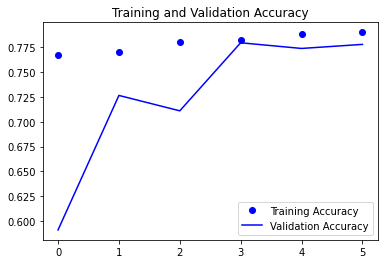

In [170]:
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

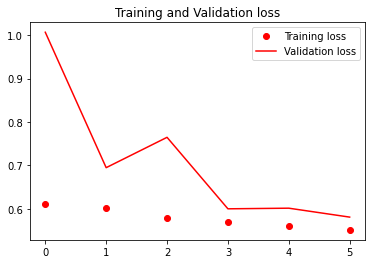

In [171]:
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

In [172]:
# predicted_classes = model.predict_classes(X_test)
predicted_classes = np.argmax(model_2_emotion.predict(X_Test), axis=-1)
y_true = np.argmax(y_Test, axis=-1)

In [173]:
y_true.shape

(1229,)

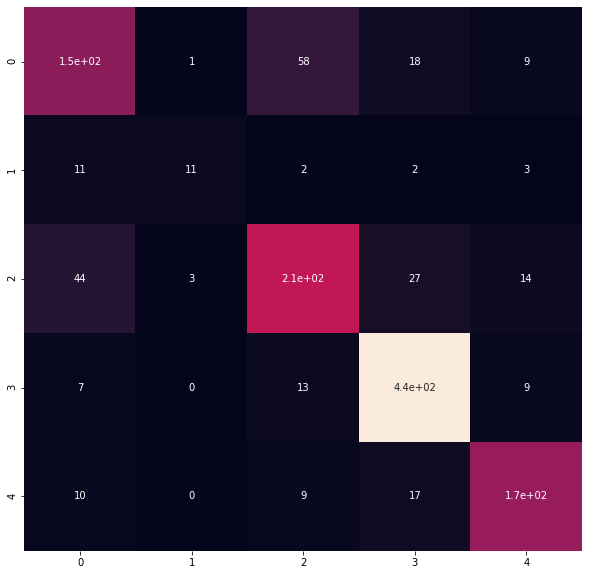

In [174]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, predicted_classes)
plt.figure(figsize = (10, 10))
sns.heatmap(cm, annot = True, cbar = False)

#### Print out a grid of 25 images along with their predicted/true label


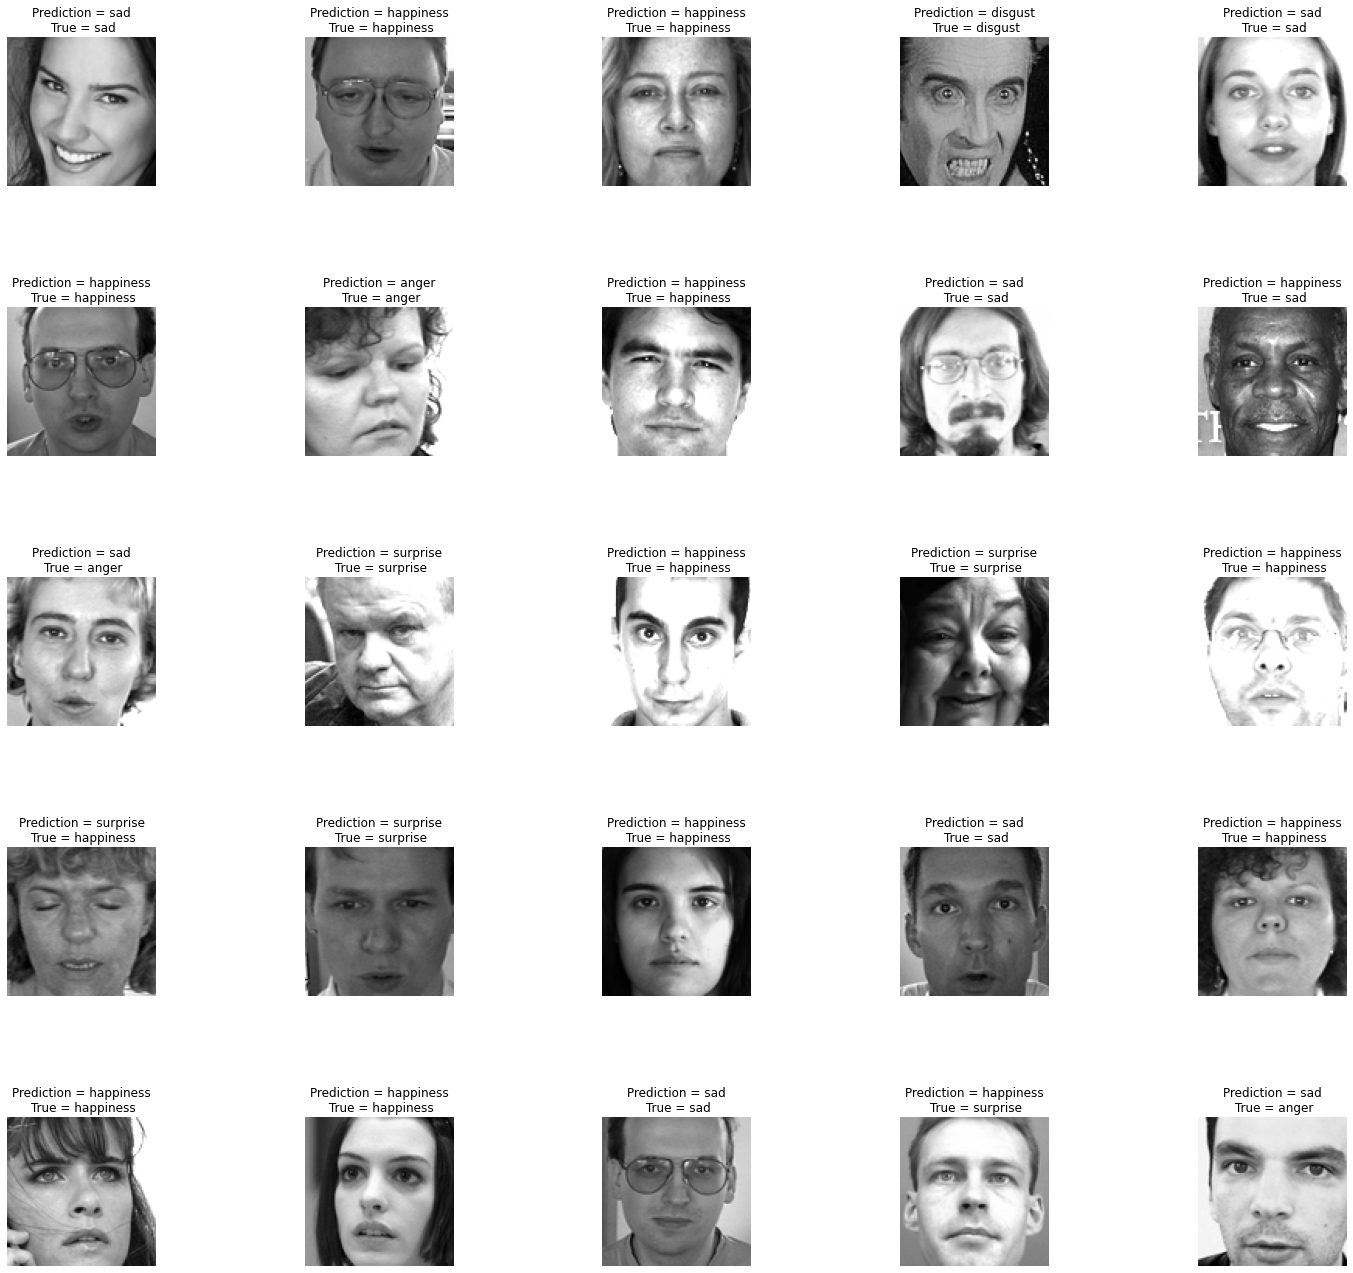

In [176]:
L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize = (24, 24))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(X_test[i].reshape(96,96), cmap = 'gray')
    axes[i].set_title('Prediction = {}\n True = {}'.format(label_to_text[predicted_classes[i]], label_to_text[y_true[i]]))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1)   

In [177]:
from sklearn.metrics import classification_report
print(classification_report(y_true, predicted_classes))

              precision    recall  f1-score   support

           0       0.68      0.64      0.66       240
           1       0.73      0.38      0.50        29
           2       0.72      0.70      0.71       294
           3       0.87      0.94      0.90       464
           4       0.83      0.82      0.82       202

    accuracy                           0.79      1229
   macro avg       0.77      0.70      0.72      1229
weighted avg       0.79      0.79      0.79      1229



## COMBINE BOTH FACIAL EXPRESSION AND KEY POINTS DETECTION MODELS

#### COMBINE BOTH MODELS (1) FACIAL KEY POINTS DETECTION AND (2) FACIAL EXPRESSION MODELS

In [178]:
def predict(X_test):

  # Making prediction from the keypoint model
  df_predict = model_1_facialKeyPoints.predict(X_test)

  # Making prediction from the emotion model
  df_emotion = np.argmax(model_2_emotion.predict(X_test), axis=-1)

  # Reshaping array from (856,) to (856,1)
  df_emotion = np.expand_dims(df_emotion, axis = 1)

  # Converting the predictions into a dataframe
  df_predict = pd.DataFrame(df_predict, columns= columns)

  # Adding emotion into the predicted dataframe
  df_predict['emotion'] = df_emotion

  return df_predict

In [179]:
df_predict = predict(X_test)

In [180]:
df_predict.head()

left_eye_center_x  left_eye_center_y  ...  mouth_center_bottom_lip_y  emotion
0          31.791649          37.833904  ...                  82.109276        3
1          65.950447          37.392105  ...                  83.587486        2
2          31.213568          37.600372  ...                  84.270325        2
3          32.344116          36.827568  ...                  81.995651        0
4          46.315788          36.430183  ...                  78.612923        3

[5 rows x 31 columns]

#### Plot a grid of 16 images along with their predicted emotion and facial key points

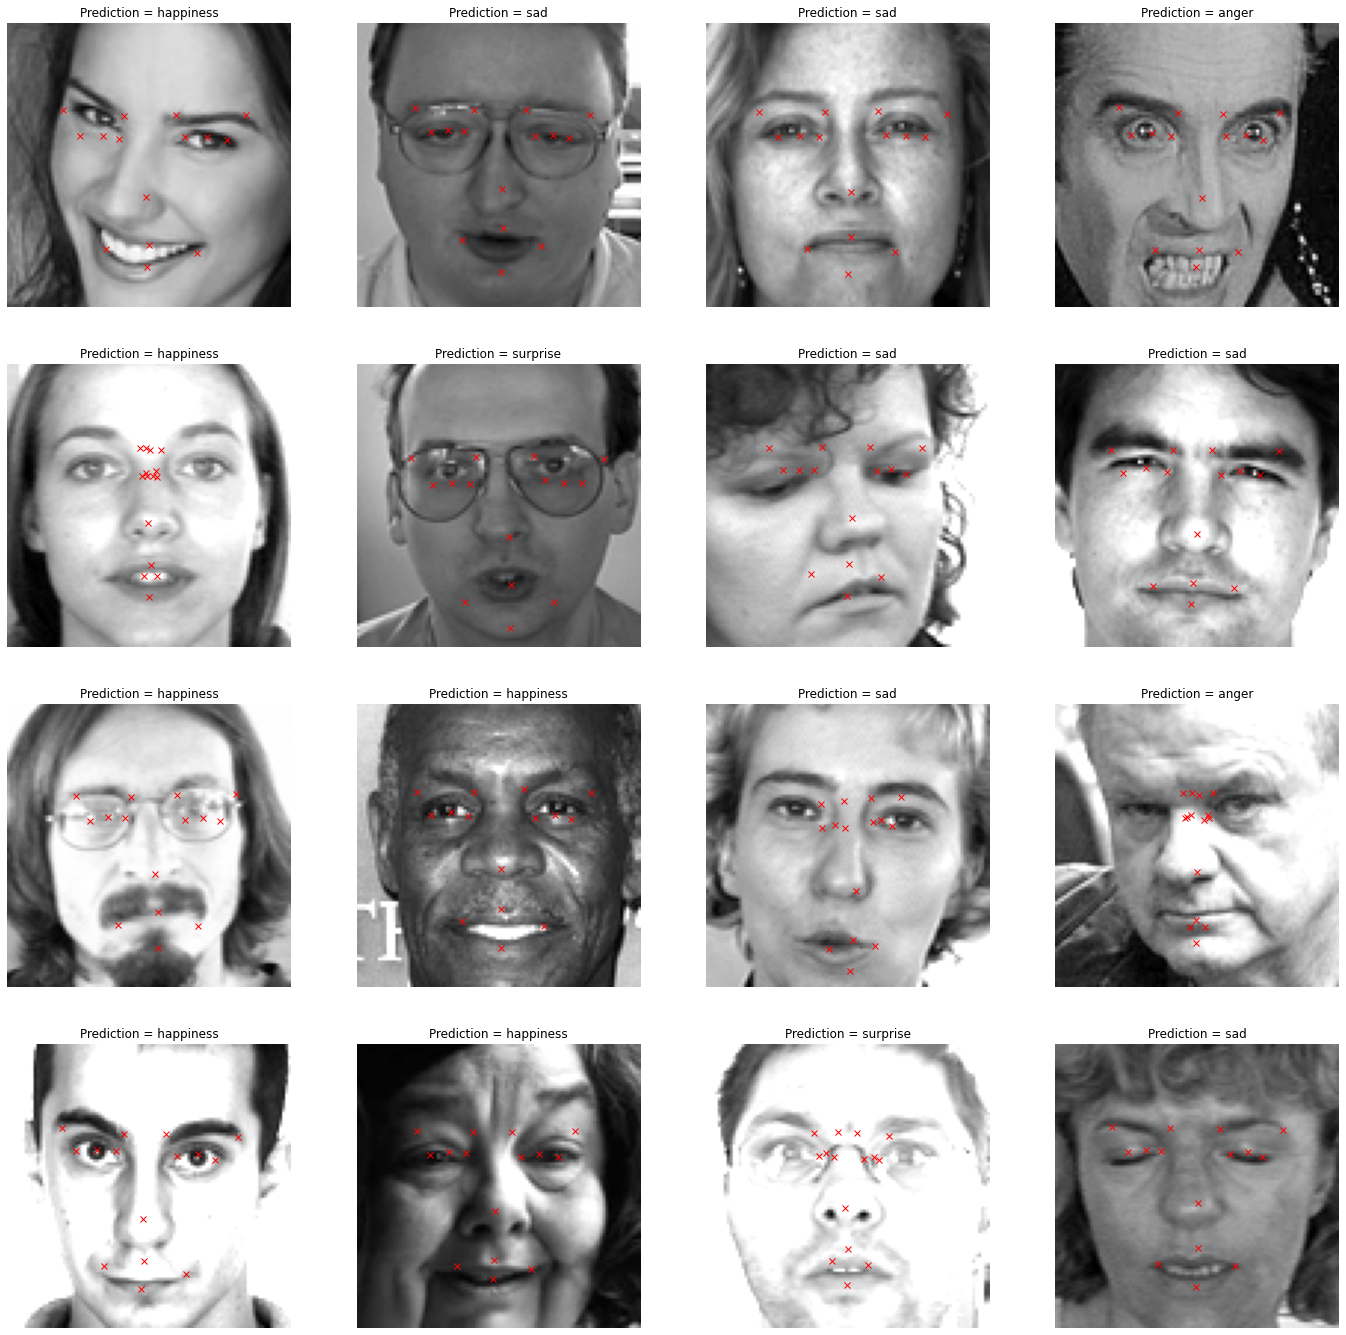

In [181]:
# Plotting the test images and their predicted keypoints and emotions

fig, axes = plt.subplots(4, 4, figsize = (24, 24))
axes = axes.ravel()

for i in range(16):

    axes[i].imshow(X_test[i].squeeze(),cmap='gray')
    axes[i].set_title('Prediction = {}'.format(label_to_text[df_predict['emotion'][i]]))
    axes[i].axis('off')
    for j in range(1,31,2):
            axes[i].plot(df_predict.loc[i][j-1], df_predict.loc[i][j], 'rx')
            

# DEPLOY BOTH TRAINED MODELS 

#### SAVE THE TRAINED MODEL FOR DEPLOYMENT

- We now need to save our trained model and it has to be saved in a SavedModel format.
- The model will have a version number and will be saved in a structured directory 
- tf.saved_model.save is a function used to build a saved model that is suitable for serving using Tensorflow Serving. 
- After the model is saved, we can now use TensorFlow Serving to start making inference requests using a specific version of our trained model "servable".
- Use SavedModel to save and load your model—variables, the graph, and the graph's metadata. 
          


In [182]:
import json
import tensorflow.keras.backend as K

def deploy(directory, model):
  MODEL_DIR = directory
  version = 1 

  # Let's join the temp model directory with our chosen version number 
  # The expected result will be = '\tmp\version number'
  export_path = os.path.join(MODEL_DIR, str(version))
  print('export_path = {}\n'.format(export_path))

  # Let's save the model using saved_model.save
  # If the directory already exists, we will remove it using '!rm' 
  # rm removes each file specified on the command line. 

  if os.path.isdir(export_path):
    print('\nAlready saved a model, cleaning up\n')
    !rm -r {export_path}

  tf.saved_model.save(model, export_path)

  os.environ["MODEL_DIR"] = MODEL_DIR

## SERVE THE MODEL USING TENSORFLOW SERVING

In [183]:
# Let's add tensorflow-model-server package to our list of packages 
!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -
!apt update

deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0  29430      0 --:--:-- --:--:-- --:--:-- 29430
OK
Get:1 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease [3,012 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:7 http://storage.googleapis.com/tensorflow-serving-apt stable/tensorflow-model-server amd64 Packages [340 B]
Get:8 http://storage.goog

In [184]:
# Let's install tensorflow model server
!apt-get install tensorflow-model-server

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  tensorflow-model-server
0 upgraded, 1 newly installed, 0 to remove and 21 not upgraded.
Need to get 223 MB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://storage.googleapis.com/tensorflow-serving-apt stable/tensorflow-model-server amd64 tensorflow-model-server all 2.4.1 [223 MB]
Fetched 223 MB in 3s (89.2 MB/s)
Selecting previously unselected package tensorflow-model-server.
(Reading database ... 146456 files and directories currently installed.)
Preparing to unpack .../tensorflow-model-server_2.4.1_all.deb ...
Unpacking tensorflow-model-server (2.4.1) ...
Setting up tensorflow-model-server (2.4.1) ...


In [185]:
# Let's run TensorFlow serving

- We will load our model and start making inferences (predictions) based on it.
- There are some important parameters:

  - rest_api_port: The port that you'll use for REST requests.
  - model_name: You'll use this in the URL of REST requests. You can choose any name
  - model_base_path: This is the path to the directory where you've saved your model.
  
- REST is a revival of HTTP in which http commands have semantic meaning. 

In [186]:
deploy('/model', model_1_facialKeyPoints)

export_path = /model/1

INFO:tensorflow:Assets written to: /model/1/assets


In [187]:
%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=4500 \
  --model_name=keypoint_model \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

Starting job # 0 in a separate thread.


In [188]:
!tail server.log

2021-02-04 09:57:03.135611: W external/org_tensorflow/tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 33554432 exceeds 10% of free system memory.
2021-02-04 09:57:03.155493: W external/org_tensorflow/tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 33554432 exceeds 10% of free system memory.
2021-02-04 09:57:03.180755: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:190] Running initialization op on SavedModel bundle at path: /model/1
2021-02-04 09:57:03.226748: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:277] SavedModel load for tags { serve }; Status: success: OK. Took 278723 microseconds.
2021-02-04 09:57:03.234956: I tensorflow_serving/servables/tensorflow/saved_model_warmup_util.cc:59] No warmup data file found at /model/1/assets.extra/tf_serving_warmup_requests
2021-02-04 09:57:03.235270: I tensorflow_serving/core/loader_harness.cc:87] Successfully loaded servable version {name: keypoint_model version: 1}
2021-02-

In [189]:
deploy('/model1', model_2_emotion)

export_path = /model1/1

INFO:tensorflow:Assets written to: /model1/1/assets


In [190]:
%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=4000 \
  --model_name=emotion_model \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

Starting job # 2 in a separate thread.


In [191]:
!tail server.log

2021-02-04 09:58:26.858220: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:206] Restoring SavedModel bundle.
2021-02-04 09:58:26.864181: I external/org_tensorflow/tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2199995000 Hz
2021-02-04 09:58:26.975373: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:190] Running initialization op on SavedModel bundle at path: /model1/1
2021-02-04 09:58:27.015198: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:277] SavedModel load for tags { serve }; Status: success: OK. Took 231053 microseconds.
2021-02-04 09:58:27.023476: I tensorflow_serving/servables/tensorflow/saved_model_warmup_util.cc:59] No warmup data file found at /model1/1/assets.extra/tf_serving_warmup_requests
2021-02-04 09:58:27.023793: I tensorflow_serving/core/loader_harness.cc:87] Successfully loaded servable version {name: emotion_model version: 1}
2021-02-04 09:58:27.025816: I tensorflow_serving/model_servers/server.c

- **Congratulations! now we have successfully loaded a servable version of our model {name: keypoint_model version: 1}** 
- **Congratulations! now we have successfully loaded a servable version of our model {name: emotion_model version: 1}** 

#### MAKE REQUESTS TO MODEL IN TENSORFLOW SERVING

In [192]:
import json

# Let's create a JSON object and make 3 inference requests
data = json.dumps({"signature_name": "serving_default", "instances": X_test[0:3].tolist()})
print('Data: {} ... {}'.format(data[:50], data[len(data)-52:]))

Data: {"signature_name": "serving_default", "instances": ... 96], [0.29019609093666077], [0.3333333432674408]]]]}


In [193]:
!pip install -q requests

In [194]:
import requests

# Function to make predictions from deployed models
def response(data):
  headers = {"content-type": "application/json"}
  json_response = requests.post('http://localhost:4500/v1/models/keypoint_model/versions/1:predict', data=data, headers=headers, verify = False)
  df_predict = json.loads(json_response.text)['predictions']
  json_response = requests.post('http://localhost:4000/v1/models/emotion_model/versions/1:predict', data=data, headers=headers, verify = False)
  df_emotion = np.argmax(json.loads(json_response.text)['predictions'], axis = 1)
  
  # Reshaping array from (856,) to (856,1)
  df_emotion = np.expand_dims(df_emotion, axis = 1)

  # Converting the predictions into a dataframe
  df_predict= pd.DataFrame(df_predict, columns = columns)

  # Adding emotion into the predicted dataframe
  df_predict['emotion'] = df_emotion

  return df_predict

In [195]:
# making prediction
df_predict = response(data)

In [196]:
df_predict

left_eye_center_x  left_eye_center_y  ...  mouth_center_bottom_lip_y  emotion
0          31.791637          37.833908  ...                  82.109268        3
1          65.950440          37.392117  ...                  83.587486        2
2          31.213566          37.600376  ...                  84.270332        2

[3 rows x 31 columns]

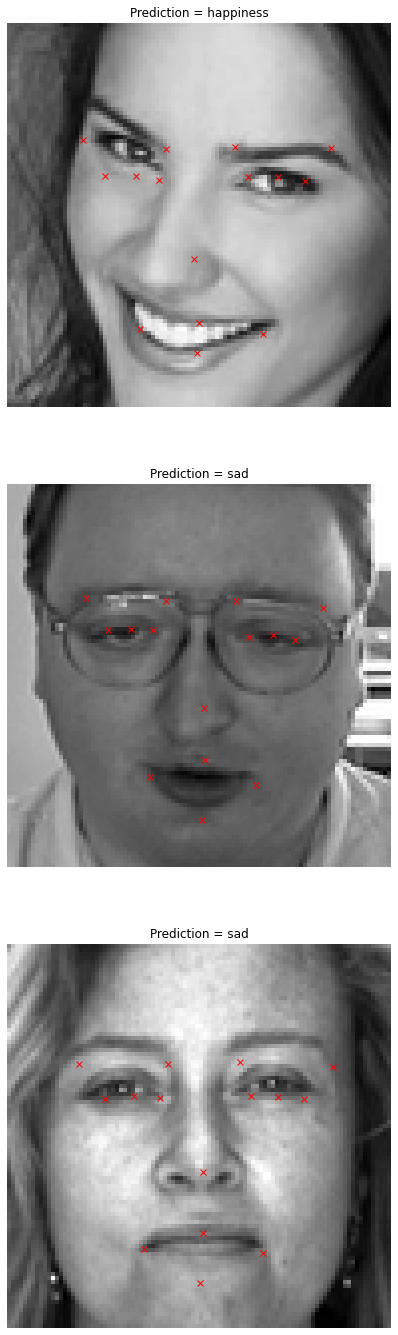

In [197]:
# Plotting the test images and their predicted keypoints and emotions

fig, axes = plt.subplots(3, 1, figsize = (24, 24))
axes = axes.ravel()

for i in range(3):

    axes[i].imshow(X_test[i].squeeze(),cmap='gray')
    axes[i].set_title('Prediction = {}'.format(label_to_text[df_predict['emotion'][i]]))
    axes[i].axis('off')
    for j in range(1,31,2):
            axes[i].plot(df_predict.loc[i][j-1], df_predict.loc[i][j], 'rx')
            